# GoogLeNet

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.layers import Input, Dense, Conv2D, MaxPool2D, AveragePooling2D, concatenate, BatchNormalization, Dropout, Rescaling, Flatten
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

2022-11-06 17:46:07.070310: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# CONSTANTS

In [3]:
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (WIDTH, HEIGHT, CHANNELS)
PATH_DATASET_TRAIN = '/mnt/files/Datasets/cats-dogs/training_set/'
PATH_DATASET_TEST = '/mnt/files/Datasets/cats-dogs/test_set/'
BATCH_SIZE = 64
LR_INITIAL = 0.01
N_EPOCHS = 90

# DATASET

## train dataset

In [4]:
train_ds = image_dataset_from_directory(directory=PATH_DATASET_TRAIN,
                                        seed=123,
                                        image_size=(WIDTH, HEIGHT),
                                        color_mode='rgb',
                                        batch_size=BATCH_SIZE)

Found 8000 files belonging to 2 classes.


## validation/test dataset

In [5]:
test_ds = image_dataset_from_directory(directory=PATH_DATASET_TEST,
                                       seed=123,
                                       image_size=(WIDTH, HEIGHT),
                                       color_mode='rgb',
                                       batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


## Visualization some examples

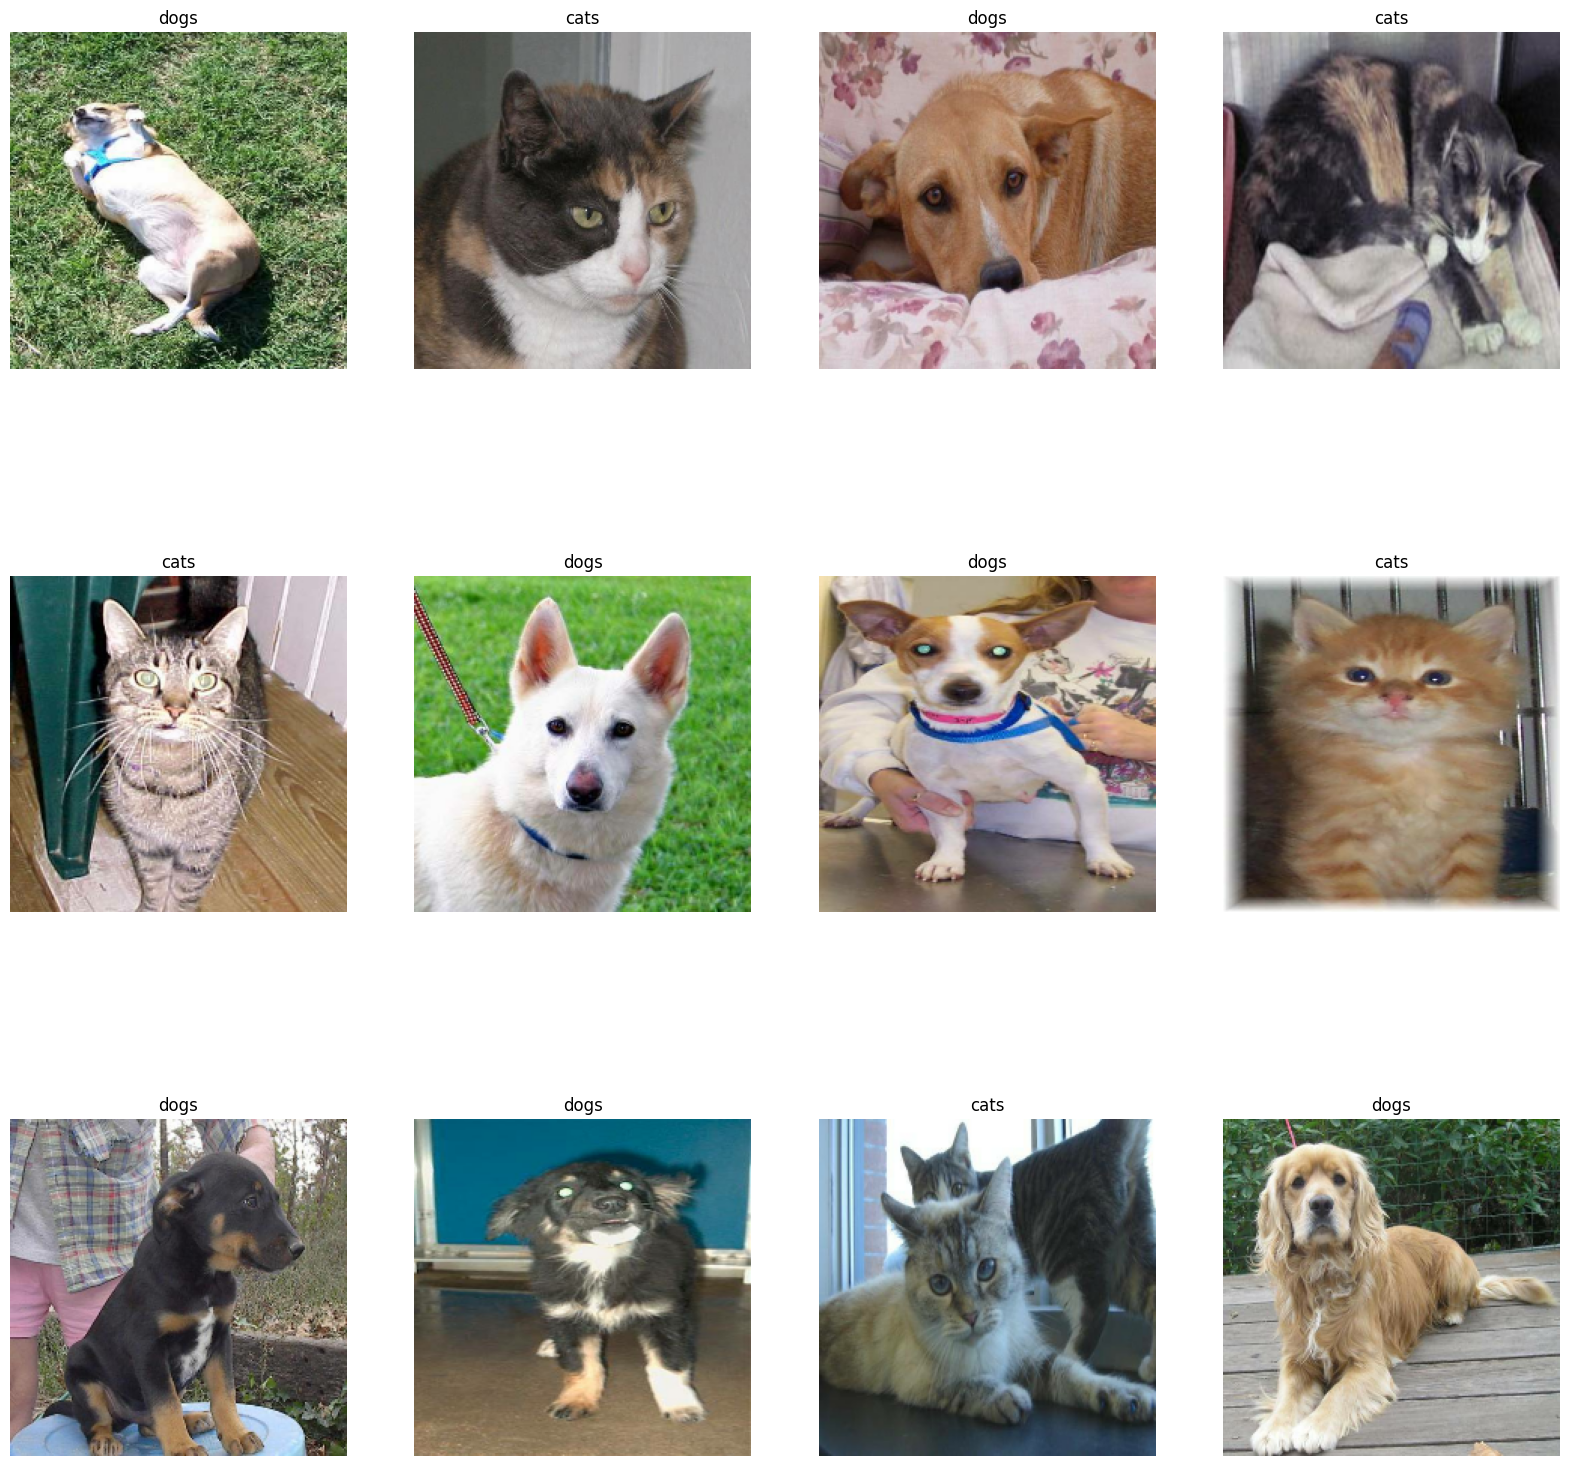

In [7]:
plt.figure(figsize=(20, 20))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# MODEL

In [9]:
def inception_module(x, 
                     filters_1x1, 
                     filters_3x3_reduce, 
                     filters_3x3, 
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    # 1x1 route = 1x1 Conv
    conv_1x1 = Conv2D(filters=filters_1x1,
                      kernel_size=(1, 1),
                      strides=(1, 1),
                      padding='same',
                      activation='relu')(x)
    
    # 3x3 route = 1x1 Conv -> 3x3 Conv
    pre_conv_3x3 = Conv2D(filters=filters_3x3_reduce,
                          kernel_size=(1, 1),
                          strides=(1, 1),
                          padding='same',
                          activation='relu')(x)
    conv_3x3 = Conv2D(filters=filters_3x3,
                      kernel_size=(3, 3),
                      strides=(1, 1),
                      padding='same',
                      activation='relu')(pre_conv_3x3)
    
    # 5x5 route = 1x1 Conv -> 5x5 Conv
    pre_conv_5x5 = Conv2D(filters=filters_5x5_reduce,
                          kernel_size=(1, 1),
                          strides=(1, 1),
                          padding='same',
                          activation='relu')(x)
    conv_5x5 = Conv2D(filters=filters_5x5,
                      kernel_size=(5, 5),
                      strides=(1, 1),
                      padding='same',
                      activation='relu')(pre_conv_5x5)
    
    
    # pool route = MaxPool -> 1x1 Conv
    pool_proj = MaxPool2D(pool_size=(3, 3),
                           strides=(1, 1),
                           padding='same')(x)
    pool_proj = Conv2D(filters=filters_pool_proj, 
                       kernel_size=(1, 1),
                       strides=(1, 1),
                       padding='same',
                       activation='relu')(pool_proj)
    
    # Concacte the deepth
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    return output

## GoogLeNet

In [10]:
def GoogLenet():
    input_layer = Input(shape=INPUT_SHAPE, name='input layer')
    rescalling_layer = Rescaling(scale=1./255, offset=0.0)(input_layer)
    X = Conv2D(filters=64,
               kernel_size=(7, 7),
               padding='same',
               strides=(2, 2),
               activation='relu',
               name='conv_1_7x7/2')(input_layer)
    X = MaxPool2D(pool_size=(3, 3),
                  strides=(2, 2),
                  padding='same',
                  name='max_pool_1_3x3/2')(X)
    X = BatchNormalization()(X)

    X = Conv2D(filters=64,
               kernel_size=(1, 1),
               padding='same',
               strides=(1, 1),
               activation='relu',
               name='conv_2_1x1/1')(X)
    X = Conv2D(filters=192,
               kernel_size=(3, 3),
               padding='same',
               strides=(1, 1),
               activation='relu',
               name='conv_3_3x3/1')(X)
    X = BatchNormalization()(X)
    X = MaxPool2D(pool_size=(3, 3),
                  strides=(2, 2),
                  padding='same',
                  name='max_pool_2_3x3/2')(X)
    # 1th inception module
    X = inception_module(x=X, 
                         filters_1x1=192,
                         filters_3x3_reduce=96,
                         filters_3x3=208,
                         filters_5x5_reduce=16,
                         filters_5x5=48,
                         filters_pool_proj=64,
                         name='inception_3a')
    # 2th inception module
    X = inception_module(x=X, 
                         filters_1x1=160,
                         filters_3x3_reduce=112,
                         filters_3x3=224,
                         filters_5x5_reduce=24,
                         filters_5x5=64,
                         filters_pool_proj=64,
                         name='inception_3b')
    X = MaxPool2D(pool_size=(3, 3),
                  strides=(2, 2),
                  padding='same')(X)
    # 3th inception module
    X = inception_module(x=X, 
                         filters_1x1=192,
                         filters_3x3_reduce=96,
                         filters_3x3=208,
                         filters_5x5_reduce=16,
                         filters_5x5=48,
                         filters_pool_proj=64,
                         name='inception_4a')


    # Extra Network 1
    X1 = AveragePooling2D(pool_size=(5, 5), strides=3, padding='valid')(X)
    X1 = Conv2D(filters=128, 
                kernel_size=(1, 1), 
                padding='same',
                activation='relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation='relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(len(class_names), activation='softmax', name='softmax0')(X1)
    


    # 4th inception module
    X = inception_module(x=X, 
                         filters_1x1=160,
                         filters_3x3_reduce=112,
                         filters_3x3=224,
                         filters_5x5_reduce=24,
                         filters_5x5=64,
                         filters_pool_proj=64,
                         name='inception_4b')
    # 5th inception module

    X = inception_module(x=X, 
                         filters_1x1=128,
                         filters_3x3_reduce=128,
                         filters_3x3=256,
                         filters_5x5_reduce=24,
                         filters_5x5=64,
                         filters_pool_proj=64,
                         name='inception_4c')
    # 6th inception module
    X = inception_module(x=X, 
                         filters_1x1=112,
                         filters_3x3_reduce=144,
                         filters_3x3=288,
                         filters_5x5_reduce=32,
                         filters_5x5=64,
                         filters_pool_proj=64,
                         name='inception_4d')
    
    # Extra Network 2
    X2 = AveragePooling2D(pool_size=(5, 5), strides=3, padding='valid')(X)
    X2 = Conv2D(filters=128, 
                kernel_size=(1, 1), 
                padding='same',
                activation='relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation='relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(len(class_names), activation='softmax', name='softmax1')(X2)
    
    # 7th inception module
    X = inception_module(x=X, 
                         filters_1x1=256,
                         filters_3x3_reduce=160,
                         filters_3x3=320,
                         filters_5x5_reduce=32,
                         filters_5x5=128,
                         filters_pool_proj=128,
                         name='inception_4e')
    X = MaxPool2D(pool_size=(3, 3),
                  strides=(2, 2),
                  padding='same')(X)


    # 8th inception module
    X = inception_module(x=X, 
                         filters_1x1=256,
                         filters_3x3_reduce=160,
                         filters_3x3=320,
                         filters_5x5_reduce=32,
                         filters_5x5=128,
                         filters_pool_proj=128,
                         name='inception_5a')
    # 9th inception module
    X = inception_module(x=X, 
                         filters_1x1=384,
                         filters_3x3_reduce=192,
                         filters_3x3=384,
                         filters_5x5_reduce=48,
                         filters_5x5=128,
                         filters_pool_proj=128,
                         name='inception_5b')
    
    X = AveragePooling2D(pool_size=(7, 7), strides=1, padding='valid')(X)
    X = Dropout(0.4)(X)
    X = Flatten()(X)   
    X = Dense(len(class_names), activation='softmax', name='softmax2')(X)  # original: 10
    model = keras.Model(inputs=input_layer, outputs=[X, X1, X2])
    return model

In [11]:
model = GoogLenet()

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input layer[0][0]']            
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                            

# CALLBACKS

In [13]:
def decay(epoch, steps=100):
    import math
    initial_lr = LR_INITIAL
    drop = 0.96
    epochs_drop = 8
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

lr_schedule = LearningRateScheduler(decay, verbose=1)

checkpoint_filepath = '/tmp/checkpoint/best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='softmax2_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [lr_schedule, model_checkpoint_callback]

# OPTIMIZER

In [14]:
optimizer = SGD(learning_rate=LR_INITIAL, momentum=0.9)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# COMPILE

In [15]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# TRAINING

In [16]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    epochs=N_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=callbacks, verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/90
125/125 [==============================] - 31s 191ms/step - loss: 2.0710 - softmax2_loss: 0.6816 - softmax0_loss: 0.7094 - softmax1_loss: 0.6799 - softmax2_accuracy: 0.5544 - softmax0_accuracy: 0.5845 - softmax1_accuracy: 0.5635 - val_loss: 2.0964 - val_softmax2_loss: 0.7032 - val_softmax0_loss: 0.7136 - val_softmax1_loss: 0.6796 - val_softmax2_accuracy: 0.5220 - val_softmax0_accuracy: 0.5420 - val_softmax1_accuracy: 0.5600 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/90
125/125 [==============================] - 21s 169ms/step - loss: 1.8607 - softmax2_loss: 0.6287 - softmax0_loss: 0.6117 - softmax1_loss: 0.6204 - softmax2_accuracy: 0.6467 - softmax0_accuracy: 0.6666 - softmax1_accuracy: 0.6571 - val_loss: 1.9433 - val_softmax2_loss: 0.6544 - val_softmax0_loss: 0.6371 - val_softmax1_loss: 0.6518 - val_softmax2_accuracy: 0.6105 - val_softmax0_accuracy: 0.6325 - val_softmax1_

# EVALUATING

In [17]:
model.load_weights('/tmp/checkpoint/best_model.h5')  # Loading the best model

In [18]:
model.evaluate(test_ds)

32/32 [==============================] - 2s 49ms/step - loss: 1.9304 - softmax2_loss: 0.6323 - softmax0_loss: 0.6251 - softmax1_loss: 0.6730 - softmax2_accuracy: 0.9155 - softmax0_accuracy: 0.9140 - softmax1_accuracy: 0.9155


[1.9304280281066895,
 0.6322515606880188,
 0.6251457929611206,
 0.6730307340621948,
 0.9154999852180481,
 0.9139999747276306,
 0.9154999852180481]

In [19]:
out = model.evaluate(test_ds)
loss, acc = out[1], out[4]
print(f"loss = {loss:.4f} | acc = {acc:.4f}")

32/32 [==============================] - 2s 49ms/step - loss: 1.9304 - softmax2_loss: 0.6323 - softmax0_loss: 0.6251 - softmax1_loss: 0.6730 - softmax2_accuracy: 0.9155 - softmax0_accuracy: 0.9140 - softmax1_accuracy: 0.9155
loss = 0.6323 | acc = 0.9155


## Curves

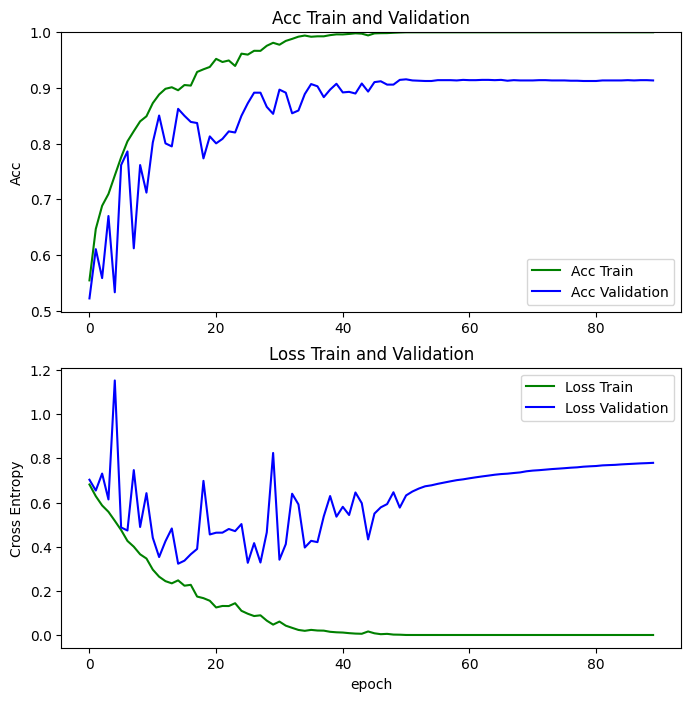

In [20]:
acc = history.history['softmax2_accuracy']
val_acc = history.history['val_softmax2_accuracy']

loss = history.history['softmax2_loss']
val_loss = history.history['val_softmax2_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, 'g', label='Acc Train')
plt.plot(val_acc, 'b', label='Acc Validation')
plt.legend(loc='lower right')
plt.ylabel('Acc')
plt.ylim([min(plt.ylim()),1.001])
plt.title('Acc Train and Validation')

plt.subplot(2, 1, 2)
plt.plot(loss, 'g', label='Loss Train')
plt.plot(val_loss, 'b', label='Loss Validation')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Loss Train and Validation')
plt.xlabel('epoch')
plt.show()

## Infering some examples (green = correct, red = wrong)

2/2 [==============================] - 1s 9ms/step


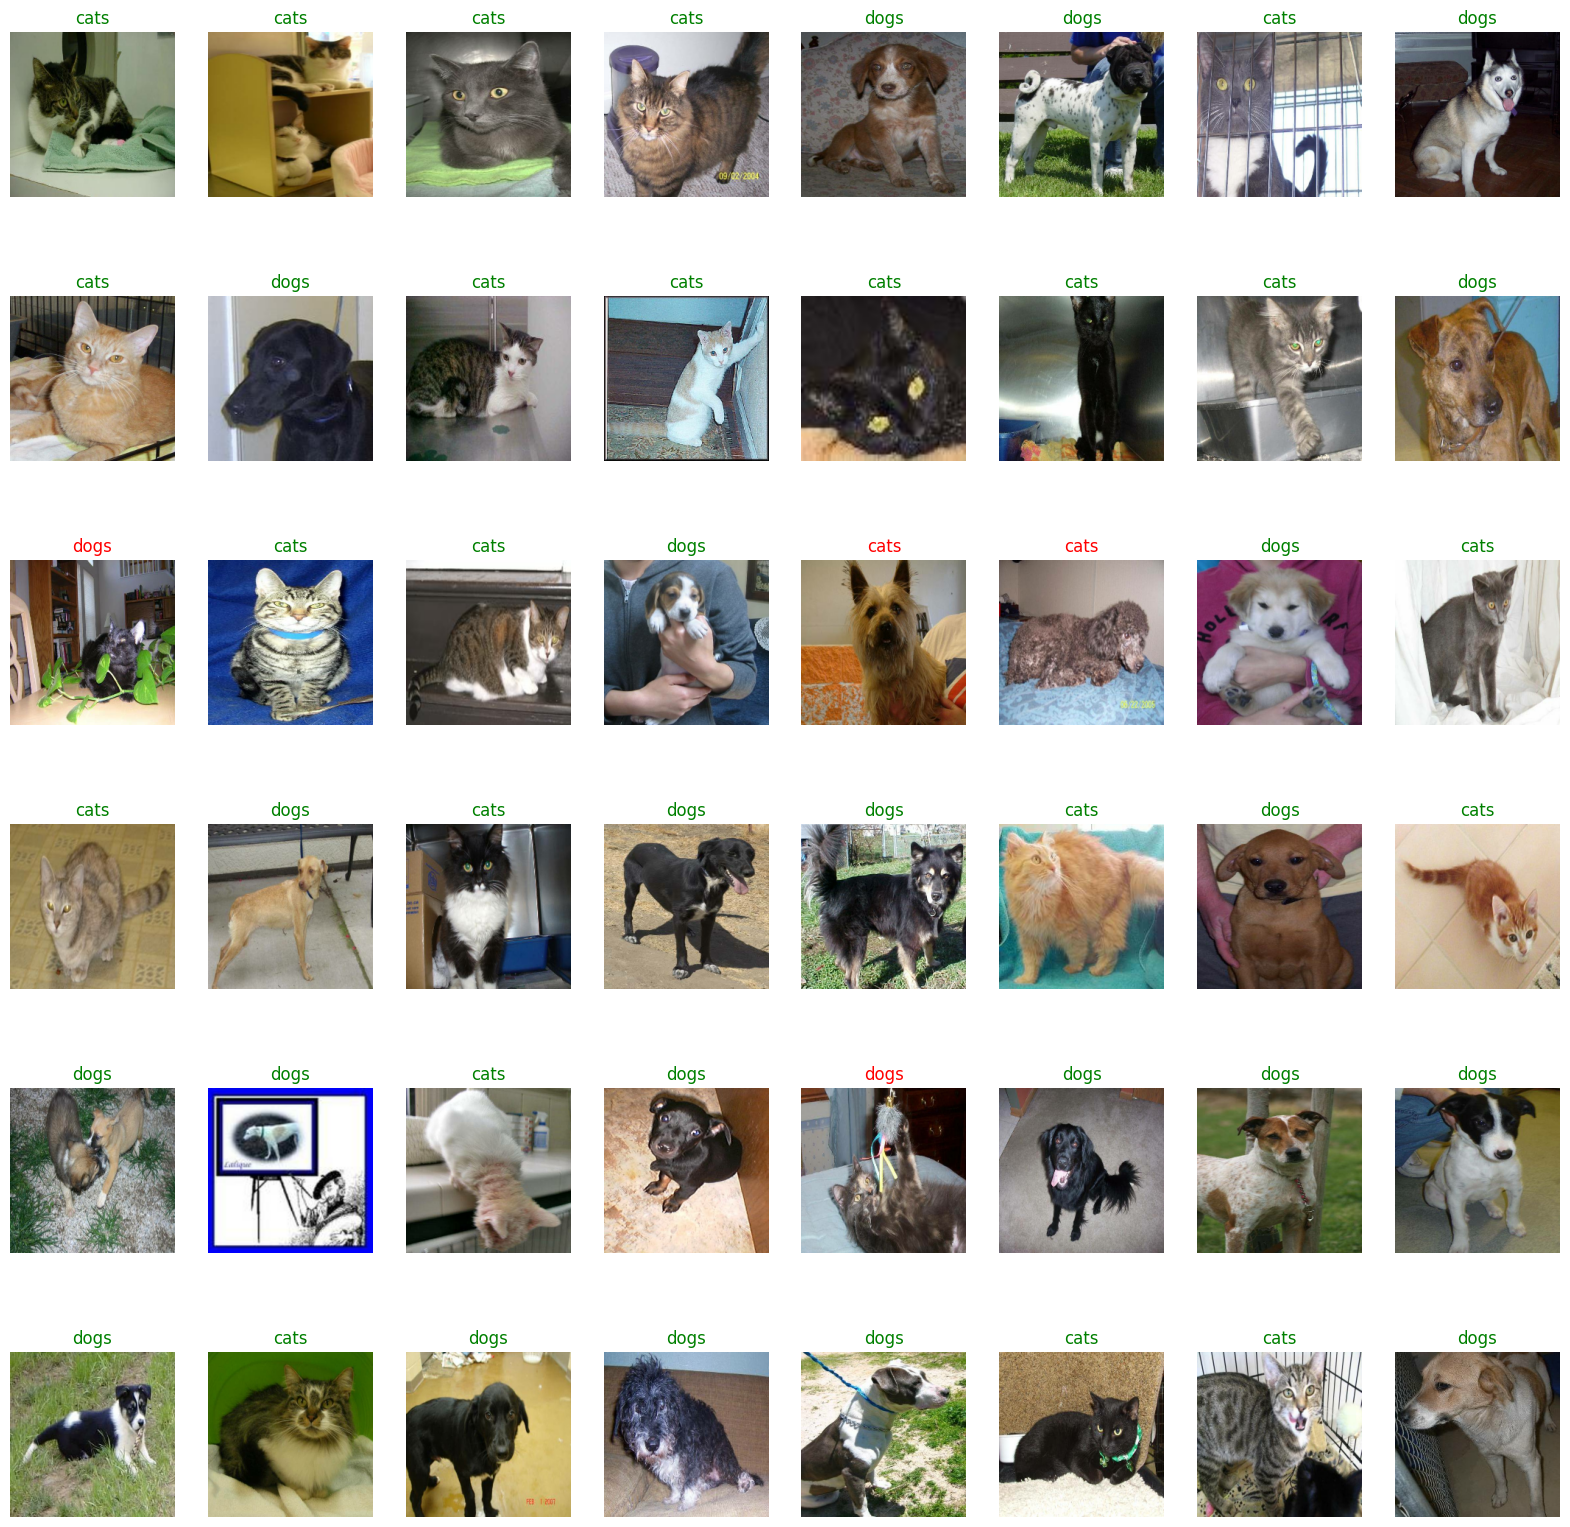

In [21]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    preds_classes = np.argmax(model.predict(images)[0], axis=1)
    
    for i in range(48):
        ax = plt.subplot(6, 8, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        if preds_classes[i] == labels[i]:
            plt.title(class_names[preds_classes[i]], color='g')
        else:
            plt.title(class_names[preds_classes[i]], color='r')
        plt.axis('off')